In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import matplotlib.pyplot as plt
import cv2
import os

2021-09-27 16:41:28.518848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def load_wav(path, sr):
    return librosa.core.load(path, sr=sr)[0]

def trim_silence(wav, top_db=23, fft_size=512, hop_size=128):
    return librosa.effects.trim(wav, top_db= top_db, frame_length=fft_size, hop_length=hop_size)[0]


def spectral_features(y, sr, n_fft, window_size):
    S, phase = librosa.magphase(librosa.stft(y=y,n_fft=n_fft, hop_length=window_size+1))

    centroid = librosa.feature.spectral_centroid(S=S,n_fft=n_fft)
    bandwidth = librosa.feature.spectral_bandwidth(S=S)
    flatness = librosa.feature.spectral_flatness(S=S)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)

    S = np.abs(librosa.stft(y,n_fft=n_fft,hop_length=window_size+1))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    
    return np.concatenate([centroid, bandwidth, flatness, rolloff, contrast], axis = 0)

In [8]:
#Use old segmentation
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR


---
# 1-Prepare Data
---



## Prepare dataset

+  coughvid 

In [9]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
data_dir = '/home/pmp/Workspace/Myoungjin/CoughData/Data'

coughvid  = data_dir+'/COUGHVID/public_dataset_wav/'
custpath  = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/custom_dataset_2/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(data_dir+'/COUGHVID/','metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][:600]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
#TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DIR'] = coughvid + TotData['uuid'] + '.wav'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
print(len(TotData))
TotData   = pd.concat([TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

1041


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,48ff5e27-832e-4450-9ea5-288a0e6967db,0,0,COVID-19,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,coughvid
1,00753bb4-cffb-472b-b391-09337558a678,0,0,healthy,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,coughvid
2,0c907751-b97d-420e-beed-ad1e09366204,0,0,healthy,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,coughvid
3,09bffe1a-63f0-4f2e-942b-f7a152b344fc,0,0,healthy,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,coughvid
4,87dcbffa-7685-46d7-a67a-d16e09b33cc0,0,0,COVID-19,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,coughvid


In [5]:
print(TotData.values)

[['2328eabf-189e-483e-9640-c0c7918f45ef' 0 0 'healthy'
  '/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID/public_dataset_wav/2328eabf-189e-483e-9640-c0c7918f45ef.wav'
  'coughvid']
 ['b235d631-6a76-4e0c-b84b-b411a1a1d289' 0 0 'healthy'
  '/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID/public_dataset_wav/b235d631-6a76-4e0c-b84b-b411a1a1d289.wav'
  'coughvid']
 ['791eccee-9d6b-48ff-8598-935a271d6548' 0 0 'healthy'
  '/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID/public_dataset_wav/791eccee-9d6b-48ff-8598-935a271d6548.wav'
  'coughvid']
 ...
 ['d6256b7d-a0cc-4928-9c43-fdfc579170e6' 0 0 'healthy'
  '/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID/public_dataset_wav/d6256b7d-a0cc-4928-9c43-fdfc579170e6.wav'
  'coughvid']
 ['70841ed6-4c74-4887-9b05-889286aeee2a' 0 0 'healthy'
  '/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID/public_dataset_wav/70841ed6-4c74-4887-9b05-889286aeee2a.wav'
  'coughvid']
 ['8ab47018-54ee-40e6-bc5e-198960809d65' 0 0 'healthy'
  '/h

In [10]:
sr = 24000

#healthy_seg = {}
#healthy_seg['id'] = []
#healthy_seg['data'] = []
#healthy_seg['covid_status'] = []

data_seg = {}
data_seg['id'] = []
data_seg['data'] = []
data_seg['covid_status'] = []

#healthy = healthy.reset_index(drop=True)
#covid = covid.reset_index(drop=True)

for i in tqdm(range(len(TotData))):
    if TotData['STATUS'][i] == 'symptomatic':
        continue
    else:
        file = TotData['DIR'][i]
        y = load_wav(file, sr)
        cough_segments, cough_mask = segment_cough(y,sr, cough_padding=0)
        for j in range(len(cough_segments)):
            data_seg['id'].append(TotData['ID'][i])
            data_seg['data'].append(cough_segments[j])
            data_seg['covid_status'].append(TotData['STATUS'][i])

100%|███████████████████████████████████████| 1041/1041 [08:45<00:00,  1.98it/s]


In [11]:
import pickle
pickle.dump( data_seg, open( "loaded_data_model2_seg_1041.pickle", "wb" ) )

In [20]:
import pickle

data_seg = {}
data_seg['data'] = []
data_seg['covid_status'] = []

with open('loaded_data_model2_seg_1041.pickle', 'rb') as f:
    data_seg = pickle.load(f)

In [21]:
#print(TotData['STATUS'][0])
#print(data_seg.values)
ds = pd.DataFrame.from_dict(data_seg)

#print(ds.values)

is_healthy_seg = ds['covid_status'] == 'healthy'
healthy_seg = ds[is_healthy_seg]
len_healthy_seg = len(healthy_seg)

is_covid_seg = ds['covid_status'] == 'COVID-19'
covid_seg = ds[is_covid_seg]
len_covid_seg = len(covid_seg)
print(len_healthy_seg)
print(len_covid_seg)
ds

1340
1140


,id,data,covid_status
0,48ff5e27-832e-4450-9ea5-288a0e6967db,"[-0.34226084, -0.45193395, -0.50728506, -0.506...",COVID-19
1,00753bb4-cffb-472b-b391-09337558a678,"[0.849215, 0.6712716, -0.05588208, -0.6054749,...",healthy
2,00753bb4-cffb-472b-b391-09337558a678,"[0.6110022, 0.8950658, 0.5829745, -0.095724426...",healthy
3,00753bb4-cffb-472b-b391-09337558a678,"[-0.69705564, -0.62722945, -0.4327317, -0.3053...",healthy
4,00753bb4-cffb-472b-b391-09337558a678,"[-0.68210304, -0.79066783, -0.72089565, -0.450...",healthy
...,...,...,...
2475,12e5dbbb-6cbc-4765-ac40-6fd3fbf155e2,"[0.34704503, 0.46957836, 0.4894573, 0.58066976...",healthy
2476,12e5dbbb-6cbc-4765-ac40-6fd3fbf155e2,"[0.5857474, 0.73729205, 0.2555101, 0.058773864...",healthy
2477,0269e593-3895-4bb4-aaba-d751df4cc058,"[-0.3013017, -0.32173976, -0.20486712, -0.0926...",healthy
2478,0d21c774-9099-4ade-8d43-b829e275fe8a,"[-0.53843725, -0.1962331, 0.33994573, 0.474566...",healthy


In [15]:
ds.values

array([['2328eabf-189e-483e-9640-c0c7918f45ef',
        array([ 0.36289632,  0.3723085 ,  0.2858499 , ..., -0.02690759,
       -0.01146876,  0.01440687], dtype=float32),
        'healthy'],
       ['2328eabf-189e-483e-9640-c0c7918f45ef',
        array([ 0.36312422,  0.27996364,  0.04781995, ...,  0.00617762,
       -0.00069924,  0.01535169], dtype=float32),
        'healthy'],
       ['b235d631-6a76-4e0c-b84b-b411a1a1d289',
        array([-0.47815052, -0.46483368, -0.43710932, ...,  0.01126644,
        0.00939665,  0.01036027], dtype=float32),
        'healthy'],
       ...,
       ['8ab47018-54ee-40e6-bc5e-198960809d65',
        array([ 0.37289196,  0.38102987,  0.37859207, ..., -0.01899354,
       -0.01559979, -0.01061054], dtype=float32),
        'healthy'],
       ['8ab47018-54ee-40e6-bc5e-198960809d65',
        array([0.35799697, 0.36748025, 0.3781875 , ..., 0.02066573, 0.02727458,
       0.02406859], dtype=float32),
        'healthy'],
       ['8ab47018-54ee-40e6-bc5e-198960809d6

## Feature Extraction

In [31]:
sr = 24000
y = ds['data'][0]

In [32]:
mfccs    = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=13)
mfccsscaled = np.mean(mfccs.T,axis=0)

In [33]:
cent = librosa.feature.spectral_centroid(y=y,sr=sr)
centscaled = np.mean(cent.T,axis=0)

bandwidth = librosa.feature.spectral_bandwidth(y=y,sr=sr)
bandwidthscaled = np.mean(bandwidth.T, axis=0)

contrast = librosa.feature.spectral_contrast(y=y,sr=sr)#
contrastscaled = np.mean(contrast.T, axis=0)#

flatness = librosa.feature.spectral_flatness(y=y)
flatnessscaled = np.mean(flatness.T, axis=0)

rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr)
rolloffscaled = np.mean(rolloff.T, axis=0)

chroma_vec = librosa.feature.chroma_stft(y=y,sr=sr)
chroma_vecscaled = np.mean(chroma_vec.T, axis=0) #12

In [34]:
test = np.concatenate([mfccsscaled, centscaled, bandwidthscaled, contrastscaled, flatnessscaled, rolloffscaled, chroma_vecscaled ])

In [35]:
test.shape

(36,)

In [18]:
features

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [28]:
features[0]

array([-4.59254532e+01,  1.87651398e+02, -7.59917450e+01,  5.17035446e+01,
       -3.61006699e+01,  3.01324081e+01, -2.33067493e+01, -1.00397692e+01,
       -1.58862476e+01, -1.04634368e+00,  4.77542543e+00, -3.45764160e+01,
        2.49967728e+01, -4.59254532e+01,  1.87651398e+02, -7.59917450e+01,
        5.17035446e+01, -3.61006699e+01,  3.01324081e+01, -2.33067493e+01,
       -1.00397692e+01, -1.58862476e+01, -1.04634368e+00,  4.77542543e+00,
       -3.45764160e+01,  2.49967728e+01,  1.49421223e+03,  1.49421223e+03,
        2.18770147e-04,  2.93960337e+03,  6.72044218e-01,  5.00423014e-01,
        3.60718668e-01,  3.04444969e-01,  3.40325534e-01,  3.60601723e-01,
        4.81812418e-01,  4.33330953e-01,  4.81491059e-01,  5.56890070e-01,
        6.39424622e-01,  7.61622965e-01])

In [30]:
test

array([-4.59254532e+01,  1.87651398e+02, -7.59917450e+01,  5.17035446e+01,
       -3.61006699e+01,  3.01324081e+01, -2.33067493e+01, -1.00397692e+01,
       -1.58862476e+01, -1.04634368e+00,  4.77542543e+00, -3.45764160e+01,
        2.49967728e+01,  1.60682519e+03,  1.49421223e+03,  1.49421223e+03,
        2.18770147e-04,  2.93960337e+03,  6.72044218e-01,  5.00423014e-01,
        3.60718668e-01,  3.04444969e-01,  3.40325534e-01,  3.60601723e-01,
        4.81812418e-01,  4.33330953e-01,  4.81491059e-01,  5.56890070e-01,
        6.39424622e-01,  7.61622965e-01])

In [22]:
custpath  = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/custom_dataset_2/'
sr = 24000
def feature_extractor(row):

    name     = row[0]
    try:
        #audio,sr = librosa.load(row[-2])
        #For MFCCS 
        audio = row[1]
        
        mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=13)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        '''
        cent = librosa.feature.spectral_centroid(y=audio,sr=sr)
        centscaled = np.mean(cent.T,axis=0)
    
        bandwidth = librosa.feature.spectral_bandwidth(y=audio,sr=sr)
        bandwidthscaled = np.mean(bandwidth.T, axis=0)

        contrast = librosa.feature.spectral_contrast(y=audio,sr=sr)
        contrastscaled = np.mean(contrast.T, axis=0)

        flatness = librosa.feature.spectral_flatness(y=audio)
        flatnessscaled = np.mean(flatness.T, axis=0)

        rolloff = librosa.feature.spectral_rolloff(y=audio,sr=sr)
        rolloffscaled = np.mean(rolloff.T, axis=0)

        chroma_vec = librosa.feature.chroma_stft(y=audio,sr=sr)
        chroma_vecscaled = np.mean(chroma_vec.T, axis=0) #12
    
        Feature_Set =  np.concatenate([mfccsscaled, centscaled, bandwidthscaled, contrastscaled, flatnessscaled, rolloffscaled, chroma_vecscaled ])
        '''
        #print(Feature_Set.shape)
    
        #Mel Spectogram
        plt.axis('off') # no axis
        plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
        melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
        s_db     = librosa.power_to_db(melspec, ref=np.max)
        librosa.display.specshow(s_db)
        savepath = os.path.join(custpath,name+'.png')
        plt.savefig(savepath, bbox_inches=None, pad_inches=0)
        plt.close()
        
    except:
        print('File cannot open')
        return None,None
    return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [ ]:
os.path.dir("/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/custom_dataset_2/")

In [23]:
idx = 0

for row in tqdm(ds.values):
    feature_set,savepath  = feature_extractor(row)
    features.append(feature_set)
    imgpaths.append(savepath)
    #diagnoses.append([row[1],row[2]])

print(len(features))
print(len(imgpaths))
#print(len(diagnoses))


100%|███████████████████████████████████████| 2480/2480 [04:42<00:00,  8.77it/s]

2480
2480


In [24]:
print(np.array(features).shape)
print(len(imgpaths))

(2480, 13)
2480


---
# 2- Data Sampling 
---

## Remove Nans

In [25]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
#cast_x = list(map(features))
#data_y = list(map(label,TotData['STATUS']))
data_y = list(map(label,ds['covid_status']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
#data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

print(len(data_x))
print(len(data_y))

2480
2480


## Prepare Data Splits
  n = NUM_shuf





In [26]:
assert len(data_x) == len(data_xx), "Data lengths do not match" #== len(data_xp)
data_len = len(data_x)
indices = np.arange(len(data_x))
#NUM_shuf= 5
#DATA    = {i:{} for i in range(NUM_shuf)}
DATA = {}
DATA['MFCCS'] = {}
DATA['MEL'] = {}
DATA['LABELS'] = {}

#for i in range(NUM_shuf):
np.random.shuffle(indices)

DATA['MFCCS'] = np.array([data_x[i] for i in indices])
DATA['MEL']   = [data_xx[i] for i in indices]
#DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
DATA['LABELS']= np.array([data_y[i] for i in indices])

In [27]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data_seg_1441_2480_mfcc13.pickle", "wb" ) )

In [3]:
import pickle

DATA = {}
DATA['MFCCS'] = {}
DATA['MEL'] = {}
DATA['LABELS'] = {}

with open('loaded_data_seg_1441_2480.pickle', 'rb') as f:
    DATA = pickle.load(f)
#pickle.load(DATA, open("loaded_data.pickle","rb"))

In [28]:
print(len(DATA['LABELS']))
data_len=len(DATA['MFCCS'])

2480


In [29]:
print(DATA['MFCCS'][0])

[ -47.50772     116.02305    -122.30644      46.19376     -79.83648
   28.62427     -19.738333    -45.57072     -15.839546    -20.426413
   -5.8526697   -15.573746      0.83439577]


## Data Generator




In [30]:

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale

        self.c          = 0
        self.on_epoch_end()

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
  
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            X[i,] = img / self.scale

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
    def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
        self.features   = data_x
        self.labels     = data_y
        self.batch_size = 48
        self.shuffle    = shuffle
        self.n_features = self.features.shape[1]
        self.n_classes  = 1
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.features) / self.batch_size))

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.features))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self,indexes):
        X = np.empty((self.batch_size, self.n_features))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(indexes):
            X[i,] = self.features[ID]
            y[i,] = self.labels[ID]
        return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
#Wrapper of two generatos for the combined input model
    
    def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
        self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
        self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
    
    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)
        X2_batch, Y_batch = self.genX2.__getitem__(index)
        X_batch = [X1_batch, X2_batch]
        return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
#Wrapper of two generatos for the combined input model
#def __init__(self, X1, X2, X3, Y, batch_size,target_size=(224,224)):
    def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
    #def __init__(self, X2, Y, batch_size,target_size=(224,224)):
        self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
        self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
        #self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)
        X2_batch, Y_batch = self.genX2.__getitem__(index)
        #X3_batch, Y_batch = self.genX3.__getitem__(index)

        X_batch = [X1_batch, X2_batch]#, X3_batch]
        return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [31]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
    def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
        super(Callback, self).__init__()
        self.test_data = test_data_gen
        self.val_labels = val_labels
        self.val_data = val_data_gen
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        y_preds = self.model.predict_generator(self.val_data)
        print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

        y_preds = self.model.predict_generator(self.test_data)
        print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [32]:
from keras.applications import ResNet50

def build_model():
    # first branch spectrogram
    
    inp1 = Input(shape=(224,224,3)) # (224,224,3)
    resnet = ResNet50(input_tensor=inp1, include_top=True, weights='imagenet', pooling = 'avg').layers[-3]
    gap = GlobalAveragePooling2D()(resnet.output)
    gap_batch_norm = BatchNormalization(axis=1)(gap)
    gap_dropout = Dropout(0.5)(gap_batch_norm)

    gmp = GlobalMaxPooling2D()(resnet.output)
    gmp_batch_norm = BatchNormalization(axis=1)(gmp)
    gmp_dropout = Dropout(0.5)(gmp_batch_norm)

    first_branch_concat = concatenate([gap_dropout, gmp_dropout], axis=-1) #axis=-1
    first_branch_norm = BatchNormalization(axis=1)(first_branch_concat)
    first_branch = Dropout(0.5)(first_branch_norm)
    
    #  second branch MFCCs
    inp2 = Input(shape=13) #(?,13)
    dense256_1 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense256_batch1 = BatchNormalization(axis=1)(dense256_1)#batchNormalization
    dense256_dropout1 = Dropout(0.5)(dense256_batch1)
    dense256_2 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(dense256_dropout1)
    dense256_batch2 = BatchNormalization(axis=1)(dense256_2)
    dense256_dropout2 = Dropout(0.5)(dense256_batch2)

    dense64_1 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp2)
    dense64_batch1 = BatchNormalization(axis=1)(dense64_1)#batchNormalization
    dense64_dropout1= Dropout(0.5)(dense64_batch1)
    dense64_2 = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(dense64_dropout1)
    dense64_batch2 = BatchNormalization(axis=1)(dense64_2)
    dense64_dropout2 = Dropout(0.5)(dense64_batch2)

    second_branch = concatenate([dense256_dropout2,dense64_dropout2],axis=-1)
    
    # merge input models
    branch_concat = concatenate([first_branch, second_branch], axis=-1) #axis=-1
    
    # interpretation model
    merge_dense = Dense(256, activation='relu')(branch_concat)
    merge_batch = BatchNormalization(axis=1)(merge_dense)
    merge_dropout = Dropout(0.5)(merge_batch)
    output = Dense(1, activation='sigmoid')(merge_dropout)

    MERGM = Model(inputs = [inp2,inp1], outputs = output)

    return MERGM

In [25]:
tf.__version__

'2.4.1'

In [43]:
from sklearn.metrics import classification_report
from keras import backend as K
# Create directory to save models
#rt_sv_dir = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/model2/'
#!rm -r {rt_sv_dir}
#os.mkdir(rt_sv_dir)
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4506)])
    except RuntimeError as e:
        # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
'''

MERGM = build_model()

MERGM.compile(
    optimizer = 'Adam',
    loss = 'BinaryCrossentropy',
    metrics=['AUC'])


tfeatures = DATA['MFCCS'][:int(0.7*data_len)]
#textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
timgs     = DATA['MEL'][:int(0.7*data_len)]
labels    = DATA['LABELS'][:int(0.7*data_len)]

test_features= DATA['MFCCS'][ int(0.7*data_len): int(0.85*data_len)]
#test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
test_imgs    = DATA['MEL'][ int(0.7*data_len): int(0.85*data_len)]
test_labels  = DATA['LABELS'][ int(0.7*data_len): int(0.85*data_len)]
                                        
val_features= DATA['MFCCS'][ int(0.85*data_len) :]
#val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
val_imgs    = DATA['MEL'][ int(0.85*data_len) :]
val_labels  = DATA['LABELS'][ int(0.85*data_len) :]
#print(tfeatures.shape)

   
#imgs_em      = TripleInputGenerator(tfeatures,timgs,labels,batch_size=48,target_size=(224,224))
#TEST          = TripleInputGenerator(test_features,test_imgs, test_labels,batch_size=48,target_size=(224,224))
#VAL         = TripleInputGenerator(val_features,val_imgs, val_labels,batch_size=48,target_size=(224,224))
imgs_em      = TripleInputGenerator(tfeatures,timgs, labels,batch_size=48,target_size=(224,224))
TEST          = TripleInputGenerator(test_features,test_imgs, test_labels,batch_size=48,target_size=(224,224))
VAL         = TripleInputGenerator(val_features,val_imgs, val_labels,batch_size=48,target_size=(224,224))


evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
#checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
#            "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
#os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
MERGM.fit_generator(
    imgs_em,
    epochs=30, #epochs 40,50
    validation_data=VAL, 
    verbose=2, 
    callbacks=[evaluator])#, checkpointer])

MERGM_Record1 = MERGM.evaluate_generator(
    TEST
)
print()
print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

print()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_val  = val_labels
y_preds_val = MERGM.predict_generator(VAL)
print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

y_test  = test_labels
y_preds_test = MERGM.predict(TEST)
print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))

print()
print('-----------------------------------------------------------------')
    
    


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
36/36 - 17s - loss: 0.9683 - auc: 0.5916 - val_loss: 147.5088 - val_auc: 0.5000


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5
Epoch 2/30
36/36 - 11s - loss: 0.8724 - auc: 0.6225 - val_loss: 44.2036 - val_auc: 0.5000


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49412479017107747


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48112535612535606
Epoch 3/30
36/36 - 11s - loss: 0.7500 - auc: 0.6728 - val_loss: 282.6895 - val_auc: 0.5000


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5
Epoch 4/30
36/36 - 11s - loss: 0.5706 - auc: 0.8100 - val_loss: 101.9135 - val_auc: 0.5000


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5
Epoch 5/30
36/36 - 11s - loss: 0.4865 - auc: 0.8617 - val_loss: 3.4318 - val_auc: 0.5206


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5948069573913355


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6201388888888889
Epoch 6/30
36/36 - 11s - loss: 0.2442 - auc: 0.9641 - val_loss: 112.7706 - val_auc: 0.5000


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5
Epoch 7/30
36/36 - 11s - loss: 0.3369 - auc: 0.9349 - val_loss: 0.7378 - val_auc: 0.5760


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.576377727775992


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6550925925925927
Epoch 8/30
36/36 - 11s - loss: 0.2200 - auc: 0.9695 - val_loss: 1.3712 - val_auc: 0.5747


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5786635236972748


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6688746438746438
Epoch 9/30
36/36 - 11s - loss: 0.1612 - auc: 0.9833 - val_loss: 0.7199 - val_auc: 0.5676


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.568556019857852


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.661502849002849
Epoch 10/30
36/36 - 12s - loss: 0.2439 - auc: 0.9656 - val_loss: 1.1497 - val_auc: 0.5726


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.571591842565806


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6595797720797721
Epoch 11/30
36/36 - 11s - loss: 0.1854 - auc: 0.9785 - val_loss: 1.1540 - val_auc: 0.5598


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5600557162755813


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.652065527065527
Epoch 12/30
36/36 - 12s - loss: 0.0954 - auc: 0.9931 - val_loss: 1.5862 - val_auc: 0.5729


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.571698989249616


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6444800569800571
Epoch 13/30
36/36 - 12s - loss: 0.0833 - auc: 0.9950 - val_loss: 0.8938 - val_auc: 0.5863


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5868066716668452


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6473646723646724
Epoch 14/30
36/36 - 12s - loss: 0.0469 - auc: 0.9981 - val_loss: 1.8424 - val_auc: 0.5533


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5580556448444588


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6511396011396011
Epoch 15/30
36/36 - 12s - loss: 0.0483 - auc: 0.9975 - val_loss: 1.8732 - val_auc: 0.5534


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5607343119397121


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6523148148148148
Epoch 16/30
36/36 - 12s - loss: 0.0324 - auc: 0.9988 - val_loss: 1.8514 - val_auc: 0.5635


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5603057252044716


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6519230769230769
Epoch 17/30
36/36 - 12s - loss: 0.0237 - auc: 0.9997 - val_loss: 1.8183 - val_auc: 0.5626


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5644487303117969


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6514245014245014
Epoch 18/30
36/36 - 12s - loss: 0.0218 - auc: 0.9998 - val_loss: 1.7259 - val_auc: 0.5703


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5698417800635738


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6602207977207979
Epoch 19/30
36/36 - 12s - loss: 0.0305 - auc: 0.9995 - val_loss: 1.4696 - val_auc: 0.5956


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5950569663202258


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6882478632478632
Epoch 20/30
36/36 - 12s - loss: 0.0354 - auc: 0.9992 - val_loss: 0.7863 - val_auc: 0.5737


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5737347762420086


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6782051282051281
Epoch 21/30
36/36 - 12s - loss: 0.0365 - auc: 0.9991 - val_loss: 0.9090 - val_auc: 0.5593


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5592699739276402


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6242165242165242
Epoch 22/30
36/36 - 12s - loss: 0.0406 - auc: 0.9990 - val_loss: 1.3627 - val_auc: 0.6034


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.60630736812029


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6956196581196582
Epoch 23/30
36/36 - 12s - loss: 0.0782 - auc: 0.9950 - val_loss: 1.3702 - val_auc: 0.6341


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6317011321832923


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6717236467236467
Epoch 24/30
36/36 - 12s - loss: 0.1295 - auc: 0.9902 - val_loss: 1.0055 - val_auc: 0.6071


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6079859994999821


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6580484330484331
Epoch 25/30
36/36 - 12s - loss: 0.1521 - auc: 0.9847 - val_loss: 0.8447 - val_auc: 0.8046


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8059930711811137


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8212250712250712
Epoch 26/30
36/36 - 12s - loss: 0.0925 - auc: 0.9930 - val_loss: 0.7654 - val_auc: 0.8378


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8386728097432051


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8553418803418804
Epoch 27/30
36/36 - 12s - loss: 0.0595 - auc: 0.9976 - val_loss: 0.7321 - val_auc: 0.8557


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8589949641058611


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8623219373219373
Epoch 28/30
36/36 - 12s - loss: 0.0352 - auc: 0.9981 - val_loss: 1.0047 - val_auc: 0.8340


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8407800278581379


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8301282051282052
Epoch 29/30
36/36 - 12s - loss: 0.0075 - auc: 1.0000 - val_loss: 0.5489 - val_auc: 0.9113


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9159255687703132


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.914351851851852
Epoch 30/30
36/36 - 12s - loss: 0.0034 - auc: 1.0000 - val_loss: 0.4172 - val_auc: 0.9444


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9451944712311154


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.948539886039886


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.40009742975234985 , AUC = 0.9496259689331055 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.9451944712311154
test 0.948539886039886

-----------------------------------------------------------------


In [11]:
MERGM_Record1 = MERGM.evaluate_generator(
    TEST
)
print()
print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

print()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_val  = val_labels
y_preds_val = MERGM.predict_generator(VAL)
print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

y_test  = test_labels
y_preds_test = MERGM.predict(TEST)
print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))

print()
print('-----------------------------------------------------------------')
    

/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.5326367020606995 , AUC = 0.9383211135864258 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.9782801261382561
test 0.9641668158224449

-----------------------------------------------------------------


In [44]:
y_p_v=[]
for i in range(len(y_preds_val)):
    if y_preds_val[i] >= 0.5:
        y_p_v.append(1)
    else:
        y_p_v.append(0)

print(classification_report(y_val[:len(y_preds_val)],y_p_v))

y_p_t = []
for i in range(len(y_preds_test)):
    if y_preds_test[i] >= 0.5:
         y_p_t.append(1)
    else:
        y_p_t.append(0)

print(classification_report(y_test[:len(y_preds_test)],y_p_t))


              precision    recall  f1-score   support

           0       0.91      0.90      0.90       183
           1       0.88      0.89      0.89       153

    accuracy                           0.90       336
   macro avg       0.89      0.90      0.90       336
weighted avg       0.90      0.90      0.90       336

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       180
           1       0.86      0.89      0.87       156

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336



+ epoch = 100, 0.89/0.93/0.86
+ epoch = 40, 0.9/0.95/0.85
+ second branch만, epoch = 100, 0.57/0.60/0.58
+ 기침소리 안자름, epoch=40, 0.57/0.52/0.64
+ 기침소리 안자름, epoch=100, 0.6/0.58/0.64
+ first branch만, epoch = 40 0.92/0.93/0.90

+ 941, 2254 feature_set 30, epoch = 40 0.94/0.93/0.94  0.94/0.94/0.95
+ 941, 2254 feature_set 36, epoch = 40 0.91/0.90/0.95  0.93/0.93/0.94
+ 1041, 2480 feature_set 36, epoch = 40 0.94/0.93/0.94 0.91/0.90/0.95

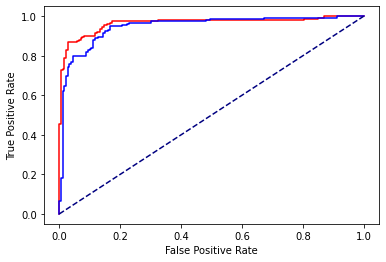

In [46]:
from sklearn.metrics import roc_curve
from scipy import interp

#y_preds_val[i]
#y_preds_test[i]
fpr, tpr, threshold = roc_curve(test_labels[:len(y_preds_test)], y_preds_test)
#feature_set36_1024_2480_epoch40_fpr_tpr = [fpr,tpr]
feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr = [fpr, tpr]

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.plot(feature_set36_1024_2480_epoch40_fpr_tpr[0], feature_set36_1024_2480_epoch40_fpr_tpr[1], 'r')
plt.plot(feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[0], feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[1], 'b')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#tpr = interp(base_fpr, fpr, tpr)
#tpr[0] = 0.0
#tprs.append(tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
pickle.dump( feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr, open( "feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr.pickle", "wb" ) )

In [49]:
import pickle

feature_set36_1024_2480_epoch40_fpr_tpr = []

with open('feature_set36_1024_2480_epoch40_fpr_tpr.pickle', 'rb') as f:
    feature_set36_1024_2480_epoch40_fpr_tpr = pickle.load(f)
    
with open('feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr.pickle', 'rb') as f:
    feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr = pickle.load(f)

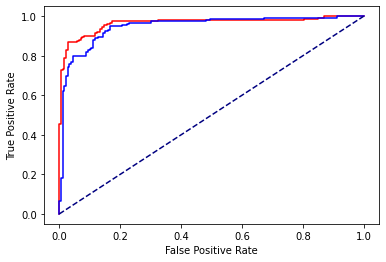

In [50]:
plt.plot(feature_set36_1024_2480_epoch40_fpr_tpr[0], feature_set36_1024_2480_epoch40_fpr_tpr[1], 'r', )
plt.plot(feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[0], feature_mfcc13_mel_1024_2480_epoch40_fpr_tpr[1], 'b')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---
# 4-Model Visualization
---

0
Num_samples: 336
acc:  0.5267857142857143
1 160 0 175
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       161
           1       0.52      1.00      0.69       175

    accuracy                           0.52       336
   macro avg       0.76      0.50      0.35       336
weighted avg       0.75      0.52      0.36       336



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


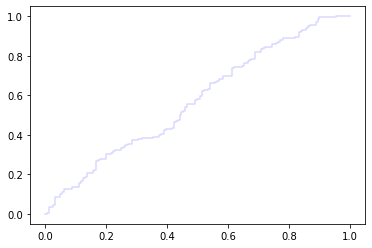

1
Num_samples: 336
acc:  0.49702380952380953
167 0 167 2
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       167
           1       1.00      0.01      0.02       169

    accuracy                           0.50       336
   macro avg       0.75      0.51      0.35       336
weighted avg       0.75      0.50      0.34       336



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


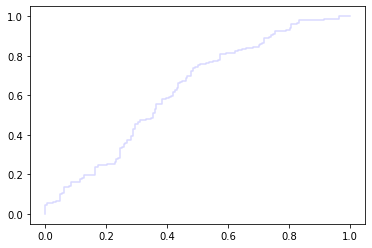

2
Num_samples: 336
acc:  0.5119047619047619
16 155 3 162
              precision    recall  f1-score   support

           0       0.84      0.09      0.17       171
           1       0.51      0.98      0.67       165

    accuracy                           0.53       336
   macro avg       0.68      0.54      0.42       336
weighted avg       0.68      0.53      0.42       336



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


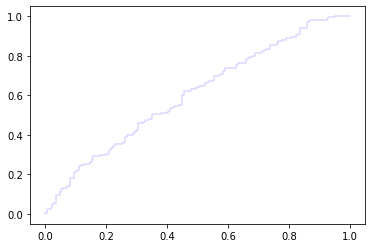

3
Num_samples: 336
acc:  0.4523809523809524
152 0 183 1
              precision    recall  f1-score   support

           0       0.45      1.00      0.62       152
           1       1.00      0.01      0.01       184

    accuracy                           0.46       336
   macro avg       0.73      0.50      0.32       336
weighted avg       0.75      0.46      0.29       336



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


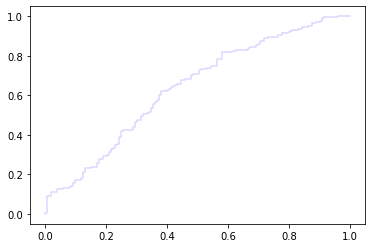

4
Num_samples: 336
acc:  0.5059523809523809
170 0 166 0
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       170
           1       0.00      0.00      0.00       166

    accuracy                           0.51       336
   macro avg       0.25      0.50      0.34       336
weighted avg       0.26      0.51      0.34       336



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/p

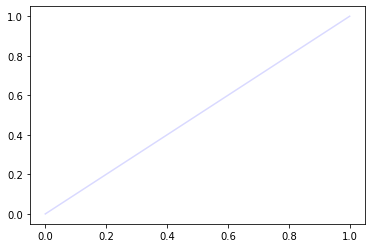

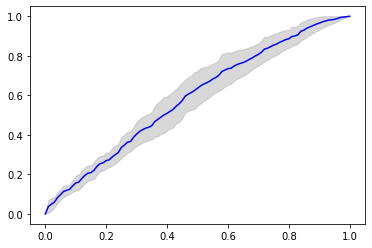

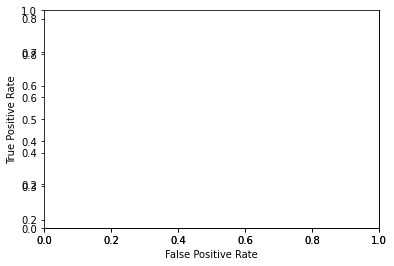

In [27]:
rt_sv_dir = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/model2/'
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: rt_sv_dir+'0/010--1.676--0.164.hdf5',
          1: rt_sv_dir+'1/010--1.556--0.051.hdf5',
          2: rt_sv_dir+'2/010--0.848--0.055.hdf5',
          3: rt_sv_dir+'3/010--2.021--0.149.hdf5',
          4: rt_sv_dir+'4/010--164.045--0.194.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
    print(iii)

    test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
    #test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
    test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
    test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
    #TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
    TEST          = TripleInputGenerator(test_features,test_imgs,test_labels,batch_size=48,target_size=(224, 224))
    
    model = keras.models.load_model(models[iii])
    y_score = model.predict(TEST)
    fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  
    print('Num_samples:', len(y_score))
    print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))
    y_pred = [] 
    for i in range(len(y_score)):
        if y_score[i] > 0.1:
            y_pred.append(1)
        else:
            y_pred.append(0)
  #print(y_pred)
  
    tn, fp, fn, tp = confusion_matrix(test_labels[:len(y_score)], y_pred).ravel()
    print(tn,fp,fn,tp)
    #print("accuracy : ",(tp+tn)/(tp+tn+fp+fn),"sen: ",tp/(tp+fn), "spe: ",tn/(fp+tn))
    print(classification_report(test_labels[:len(y_score)],y_pred))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    plt.show()
    #print(tpr)
    #print(fpr)
##
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr,mean_tprs,'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.show()

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig('roc_curve.png')
plt.show()